In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import DataLoader, NeighborSampler

In [2]:
# 1. Define the GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, adjs):
        # For the first convolution layer
        x = self.conv1(x, adjs[0].edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # For the second convolution layer
        x = self.conv2(x, adjs[1].edge_index)
        
        return x

In [3]:
# Root
from MyDataset import MyDataset

root = '../../train_val_test_dataset/IEEE_Case118/UC'

# Load all data with empty input
data = MyDataset(root=root, data_list=[])

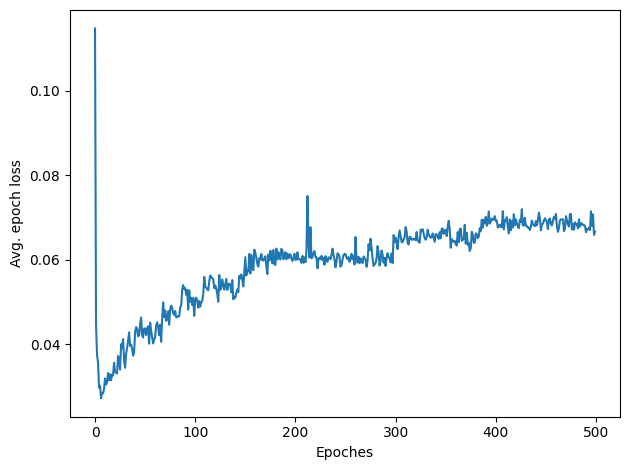

In [4]:
# Assuming you have a data object with the graph
# data = ...

epochs = 500

batch_size = 16

# 2. Initialize the GraphSAGE model
in_channels = data.num_features
hidden_channels = 32
out_channels = data.num_classes  # assuming classification task
model = GraphSAGE(in_channels, hidden_channels, out_channels)

# 3. Set up the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 4. Configure the NeighborSampler for mini-batch training
loader = NeighborSampler(data.edge_index, sizes=[4, 4], batch_size=batch_size, shuffle=True)

# 5. Training loop
epoch_loss = []
model.train()
for epoch in range(epochs):  # running for 10 epochs as an example
    batch_loss = []
    for batch_size, n_id, adjs in loader:
        # Zero out gradients
        optimizer.zero_grad()

        # Get node features and forward through the model
        out = model(data.x[n_id], adjs)
        
        # Computing loss only for the primary nodes (hence n_id[:batch_size])
        loss = F.binary_cross_entropy_with_logits(out[:batch_size], data.y[n_id[:batch_size]])
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update the model's weights

        batch_loss.append(loss.item())

    epoch_loss.append(np.mean(batch_loss))

plt.plot(epoch_loss)
plt.xlabel('Epoches')
plt.ylabel('Avg. epoch loss')
plt.tight_layout()
plt.show()
plt.close('all')